# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.16 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import torch
import matplotlib.pyplot as plt

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Train Agent in the Environment

In the next code cell, the multi agent DDPG is initialized and trained to solve th

In [5]:
from MaDDPG import MaDDPGAgent
maddpg = MaDDPGAgent(state_size=state_size, action_size=action_size, warmup=200, random_seed=0, nb_agents=num_agents)

In [7]:
# Set the number of maximum timesteps per epoch
timesteps = 1500

# Set the number of episodes to run the simulation
episodes = 50000

scores_window = deque(maxlen=100)           # last 100 scores
scores_total = []                           # scores per epoch for each agent

cnt=0
for episode in range(1, episodes+1):
    maddpg.reset()
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                    # initialize the score (for each agent)
    
    for t in range(timesteps):
        # Predict the best action for the current state. 
        actions = maddpg.act(states, cnt, add_noise = True)
        cnt+=1
        
        # Action is performed and new state, reward, info are received. 
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        
        # current state, action, reward, new state are stored in the experience replay
        maddpg.step(states, actions, rewards, next_states, dones)
        
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break 
    
    scores_window.append(np.max(scores))       # save most recent score
    scores_total.append(np.max(scores))        # save every score per epoch
    print('\rTotal score for episode {}: {}'.format(episode, np.max(scores)), end="")
    if episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
    if np.mean(scores_window)>0.5:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode-100, np.mean(scores_window)))
        for i in range(num_agents):
            torch.save(maddpg.agents[i].actor_local.state_dict(), 'checkpoint_actor_agent_{}_episode_{}.pth'.format(i, episode-100))
            torch.save(maddpg.agents[i].critic_local.state_dict(), 'checkpoint_critic_agent_{}_episode_{}.pth'.format(i, episode-100))
        break

Episode 100	Average Score: 0.010000000149011612
Episode 200	Average Score: 0.0000000000149011612
Episode 300	Average Score: 0.0100000000149011612
Episode 400	Average Score: 0.0100000000149011612
Episode 500	Average Score: 0.0100000000149011612
Episode 600	Average Score: 0.0100000000149011612
Episode 700	Average Score: 0.0100000000149011612
Episode 800	Average Score: 0.0000000000149011612
Episode 900	Average Score: 0.0100000000149011612
Episode 1000	Average Score: 0.000000000149011612
Episode 1100	Average Score: 0.0100000000149011612
Episode 1200	Average Score: 0.0100000000149011612
Episode 1300	Average Score: 0.0000000000149011612
Episode 1400	Average Score: 0.0100000000149011612
Episode 1500	Average Score: 0.0100000000149011612
Episode 1600	Average Score: 0.0100000000149011612
Episode 1700	Average Score: 0.0100000000149011612
Episode 1800	Average Score: 0.0109000000171363354
Episode 1900	Average Score: 0.0109000000171363354
Episode 2000	Average Score: 0.0100000000149011612
Episode 210

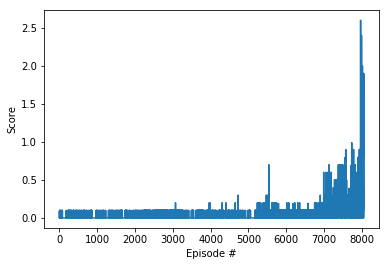

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_total)), scores_total)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('plot_of_rewards.png')
#plt.show()

When finished, you can close the environment.

In [ ]:
env.close()